In [112]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pylab
import re
import sympy as sp
import glob
from scipy.optimize import curve_fit
sp.init_printing()
%matplotlib inline

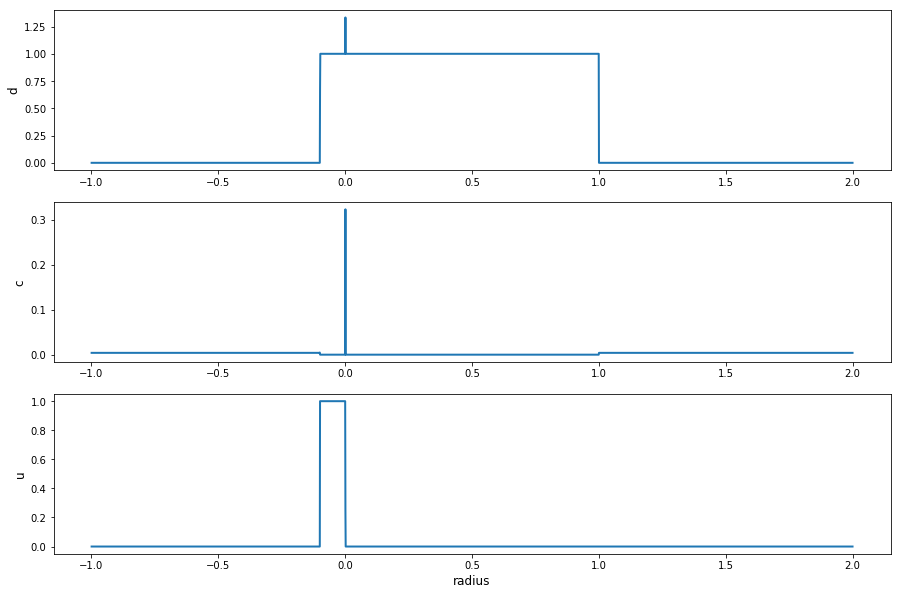

In [113]:
# Read the value fom the HDF5 File
with h5py.File("../res/gamma5_3/res_0.1/snapshot_0.h5", "r") as f:
    d_list = np.array(f['density'])
    u_list = np.array(f['x_velocity'])
    x_list = np.array(f['grid'])
    p_list = np.array(f['pressure'])
    
# The adiabatic index
g = 5./3.

c_list = np.sqrt(g * p_list / d_list)

# Plot hydrodynamic variables vs the 1D position axis (x)
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
ax[0].plot(x_list, d_list, linewidth=2)
ax[1].plot(x_list, c_list, linewidth=2) 
ax[2].plot(x_list, u_list, linewidth=2)

# Axis labels
ax[0].set_ylabel("d", fontsize='large')
ax[1].set_ylabel("c", fontsize='large')
ax[2].set_ylabel("u", fontsize='large')
ax[2].set_xlabel("radius", fontsize='large')

In [9]:
# Load the text file with the velocities
raw_dat = np.loadtxt("../res/gamma5_3/res_0.4/velocity_history.txt")

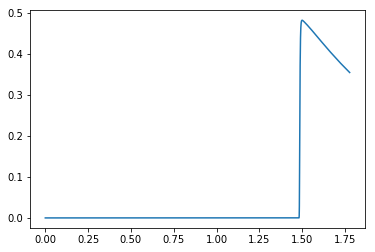

In [10]:
plt.plot(raw_dat[:,0], raw_dat[:,1])

In [11]:
"""
This cell contains helper functions for the data analysis
pipeline in this file. 
"""

def extract_index_from_filename(fname):
    """
    Get the number suffix from the filename
    """
    return int(re.search(r'_(\d+).', fname).group(1))


def extract_index_from_folder(folder):
    """
    Get the number suffix from a folder name
    """
    return float(re.search(r'_(\d+\.\d+)', folder).group(1))

    
def full_path(*args):
    """
    Args are strings. Join all of the strings to form a file path.
    If the string ends with `/` do not append another one otherwise
    append a `/` to the string. 
    """
    path = ""
    for item in args:
        if item[-1] == "/":
            path += item
        else:
            path += item + "/"
            
    return path[:-1]


def get_files(folder):
    """
    Get all the snapshots from a folder as sorted list.
    """
    files = glob.glob(full_path(folder, "/snapshot_*.h5"))
    files = [f[len(folder) + 1:] for f in files]
    return sorted(files, key=extract_index_from_filename)


def get_folders(upper):
    """
    Get all the results folders for a value of gamma.
    """
    folders = glob.glob(full_path(upper, "res_*"))
    folders = [f[len(upper) + 1:] for f in folders]
    return sorted(folders, key=extract_index_from_folder)

def sample_velocity(fname, position):
    """
    Sample (interpolate) the velocity at x location `position'
    for h5 file `fname'.
    """
    with h5py.File(fname, 'r') as f:
        u_list = np.array(f['x_velocity'])
        x_list = np.array(f['grid'])
        
    return np.interp(position, x_list, u_list)

In [14]:
UPPER = "../res/gamma5_3"
FOLDER = "%sres_0.4" % UPPER

folders = get_folders(UPPER)
files = get_files(FOLDER)

In [15]:
all_files = []

for f in folders:
    files = get_files(full_path(UPPER, f))
    all_files.append((f, files))

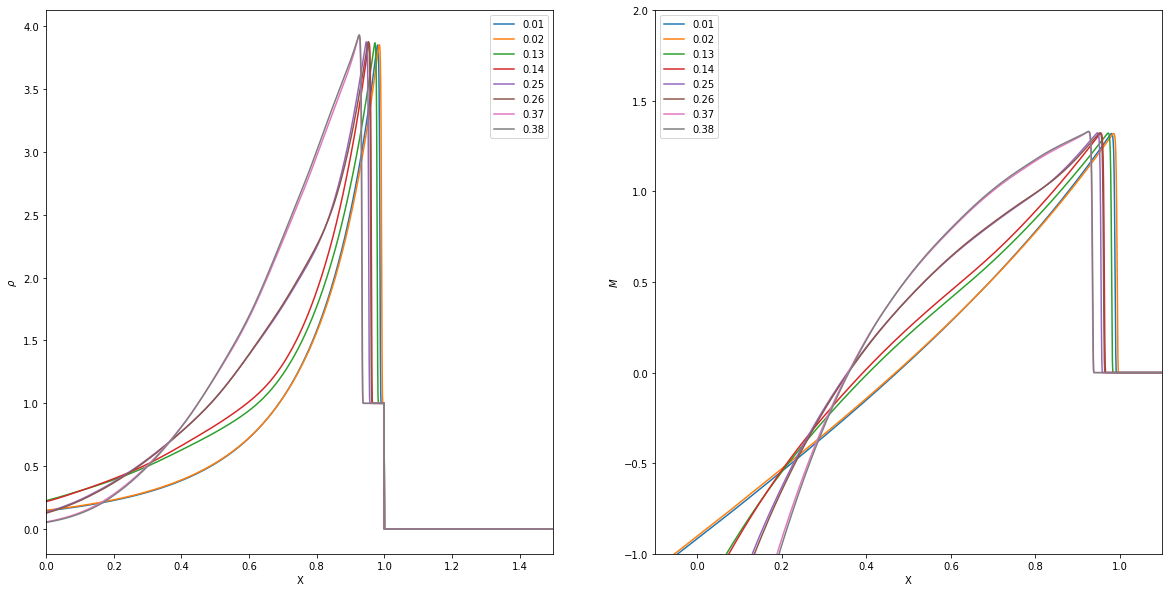

In [16]:
# Plot the maximum frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

skip = 0
for key, item in all_files:
    if skip > 1:
        skip = (skip + 1) if skip < 11 else 0
        continue
    
    sub = int(0.25 * len(item))
    with h5py.File(full_path(UPPER, key, item[-sub]), 'r') as f:
        d_list = np.array(f['density'])
        u_list = np.array(f['x_velocity'])
        x_list = np.array(f['grid'])
        p_list = np.array(f['pressure'])

    # The adiabatic index
    g = 5./3.

    c_list = np.sqrt(g * p_list / d_list)
    
    ax1.plot(x_list, d_list, label=extract_index_from_folder(key))
    ax2.plot(x_list, u_list/c_list, label=extract_index_from_folder(key))
    
    skip += 1

ax1.set_xlim(0, 1.5)
ax1.legend()
ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-1, 2)
ax2.legend()

# Ax1 is density vs position
# Ax2 is v / c = M vs Position

ax1.set_xlabel(r"X")
ax1.set_ylabel(r"$\rho$")

ax2.set_xlabel(r"X")
ax2.set_ylabel(r"$M$")
pass

In [29]:
# Analyse the breakout velocity vs size of impactor.
breakout_v = []
impactors = []

for folder in folders:
    impactors.append(extract_index_from_folder(folder))

In [30]:
for folder in folders:
    breakout_v.append(np.max([sample_velocity(f, 0.99) for f in glob.glob(UPPER + "/" + folder + "/snapshot_*.h5")]))

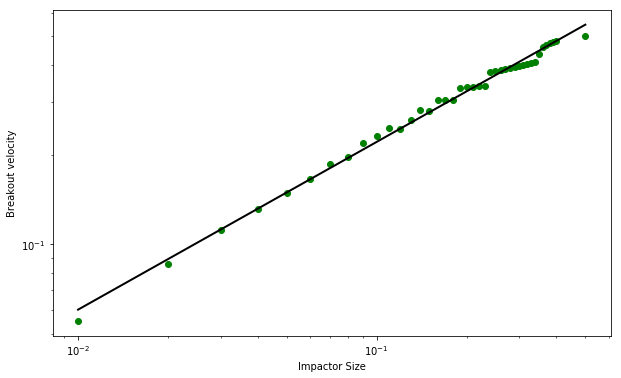

In [120]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(impactors, breakout_v, 'go')
ax.set(xlabel = "Impactor Size",
       ylabel = "Breakout velocity")
pass

# Fit the function
coeffs = np.polyfit(np.log(impactors),np.log(breakout_v),deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))
                 
ax.loglog(impactors, yfit(impactors), 'k', linewidth=2)

fig.savefig('figures/breakout.pdf')

In [110]:
poly

poly1d([ 0.56340591, -0.21435721])

So we conclude for $\gamma = 5/3$ we have a relation as:

$$ \log v_b = 0.56 \log I_w - 0.21  $$

$$ v_b \propto I_w^{0.56} \approx I_w^{3/5} $$

In [114]:
3./5.